In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from PIL import Image

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [6]:
RESCALE_SIZE = 100 #100 #160 #224

# dataset
данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw  
    Внутри:  
        - celebA_imgs — папка с выровненными картинками;  
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;  
        - celebA_train_split.txt — файл со сплитом на train/val/test.  
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.  

In [7]:
#read attrs
df_attrs = pd.read_csv("/kaggle/input/celeba/data/celebA_train_500/celebA_anno.txt", header=None, sep=' ')
df_attrs.columns = ['name_img', 'id']
df_attrs.head()

,name_img,id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


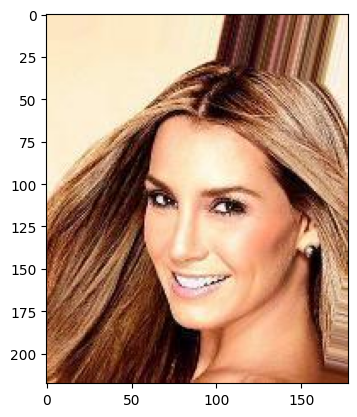

In [8]:
img = skimage.io.imread("/kaggle/input/celeba/data/celebA_train_500/celebA_imgs/000001.jpg")
plt.imshow(img);

In [9]:
#train val test split
split = pd.read_csv("/kaggle/input/celeba/data/celebA_train_500/celebA_train_split.txt", header=None, sep=' ')
split.columns = ['name_img', 'class']
split.head()

,name_img,class
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


In [10]:
class CustomDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, labels, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        self.labels = labels
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = np.array(Image.open(f'/kaggle/input/celeba/data/celebA_train_500/celebA_imgs/{file}'))
        image = Image.fromarray(image[77:-41,45:-50])
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.RandomRotation(degrees=30),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        aug = transforms.Compose([
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip()
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)       
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'train':
            x = aug(x)

        #label = self.labels[index]
        label = self.labels[self.files[index]]
        return x, label

    def _prepare_sample(self, image):
#         padding = transforms.Pad(padding=((RESCALE_SIZE - image.size[1]) // 2, (RESCALE_SIZE - image.size[0]) // 2))
#         image = padding(image)
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
train_files = list(split[split['class'] == 0]['name_img'])
val_files = list(split[split['class'] == 1]['name_img'])
test_files = list(split[split['class'] == 2]['name_img'])

In [12]:
labels = dict(zip(df_attrs['name_img'], df_attrs['id']))

In [13]:
# read images
train_dataset = CustomDataset(train_files, labels, mode='train')
val_dataset = CustomDataset(val_files, labels, mode='val')
test_dataset = CustomDataset(test_files, labels, mode='test')

In [14]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model

In [12]:
# Set the seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [13]:
df_attrs['id'].nunique()

500

In [14]:
n_classes = 500

In [16]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
model = models.resnet50(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s] 


In [16]:
# model

In [17]:
# Freeze all layers except the last two residual blocks and the fully connected layer
for param in model.parameters():
    param.requires_grad = False
    
for param in model.layer2.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True


model.fc = nn.Sequential(
                    nn.Linear(model.fc.in_features, n_classes),
                    nn.BatchNorm1d(n_classes),
                    nn.ReLU(inplace=True),
                    nn.Linear(n_classes, n_classes),
)

loss_fn = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=24)

In [18]:
n_epochs = 12
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in tqdm_notebook(range(n_epochs)):
    # Training phase
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples
    
    train_losses.append(average_loss)
    train_acc.append(accuracy)

    print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.4f}")
    
    # Validation phase
    model.eval()
    validation_loss = 0.0
    val_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            validation_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    avg_val_loss = validation_loss / len(val_loader)
    val_accuracy = val_correct / val_total_samples
    
    val_losses.append(avg_val_loss)
    val_acc.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Val Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

/tmp/ipykernel_26/1742641611.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1/12], Train Loss: 5.7859, Train Accuracy: 0.0533
Epoch [1/12], Val Loss: 5.0372, Validation Accuracy: 0.1496
Epoch [2/12], Train Loss: 4.4887, Train Accuracy: 0.2747
Epoch [2/12], Val Loss: 4.0881, Validation Accuracy: 0.3222
Epoch [3/12], Train Loss: 3.3924, Train Accuracy: 0.5157
Epoch [3/12], Val Loss: 3.3432, Validation Accuracy: 0.4473
Epoch [4/12], Train Loss: 2.3711, Train Accuracy: 0.7143
Epoch [4/12], Val Loss: 2.7223, Validation Accuracy: 0.5559
Epoch [5/12], Train Loss: 1.5067, Train Accuracy: 0.8548
Epoch [5/12], Val Loss: 2.2890, Validation Accuracy: 0.6124
Epoch [6/12], Train Loss: 0.8566, Train Accuracy: 0.9369
Epoch [6/12], Val Loss: 1.9552, Validation Accuracy: 0.6560
Epoch [7/12], Train Loss: 0.4375, Train Accuracy: 0.9747
Epoch [7/12], Val Loss: 1.7324, Validation Accuracy: 0.6832
Epoch [8/12], Train Loss: 0.2303, Train Accuracy: 0.9908
Epoch [8/12], Val Loss: 1.6042, Validation Accuracy: 0.6944
Epoch [9/12], Train Loss: 0.1234, Train Accuracy: 0.9973
Epoch [

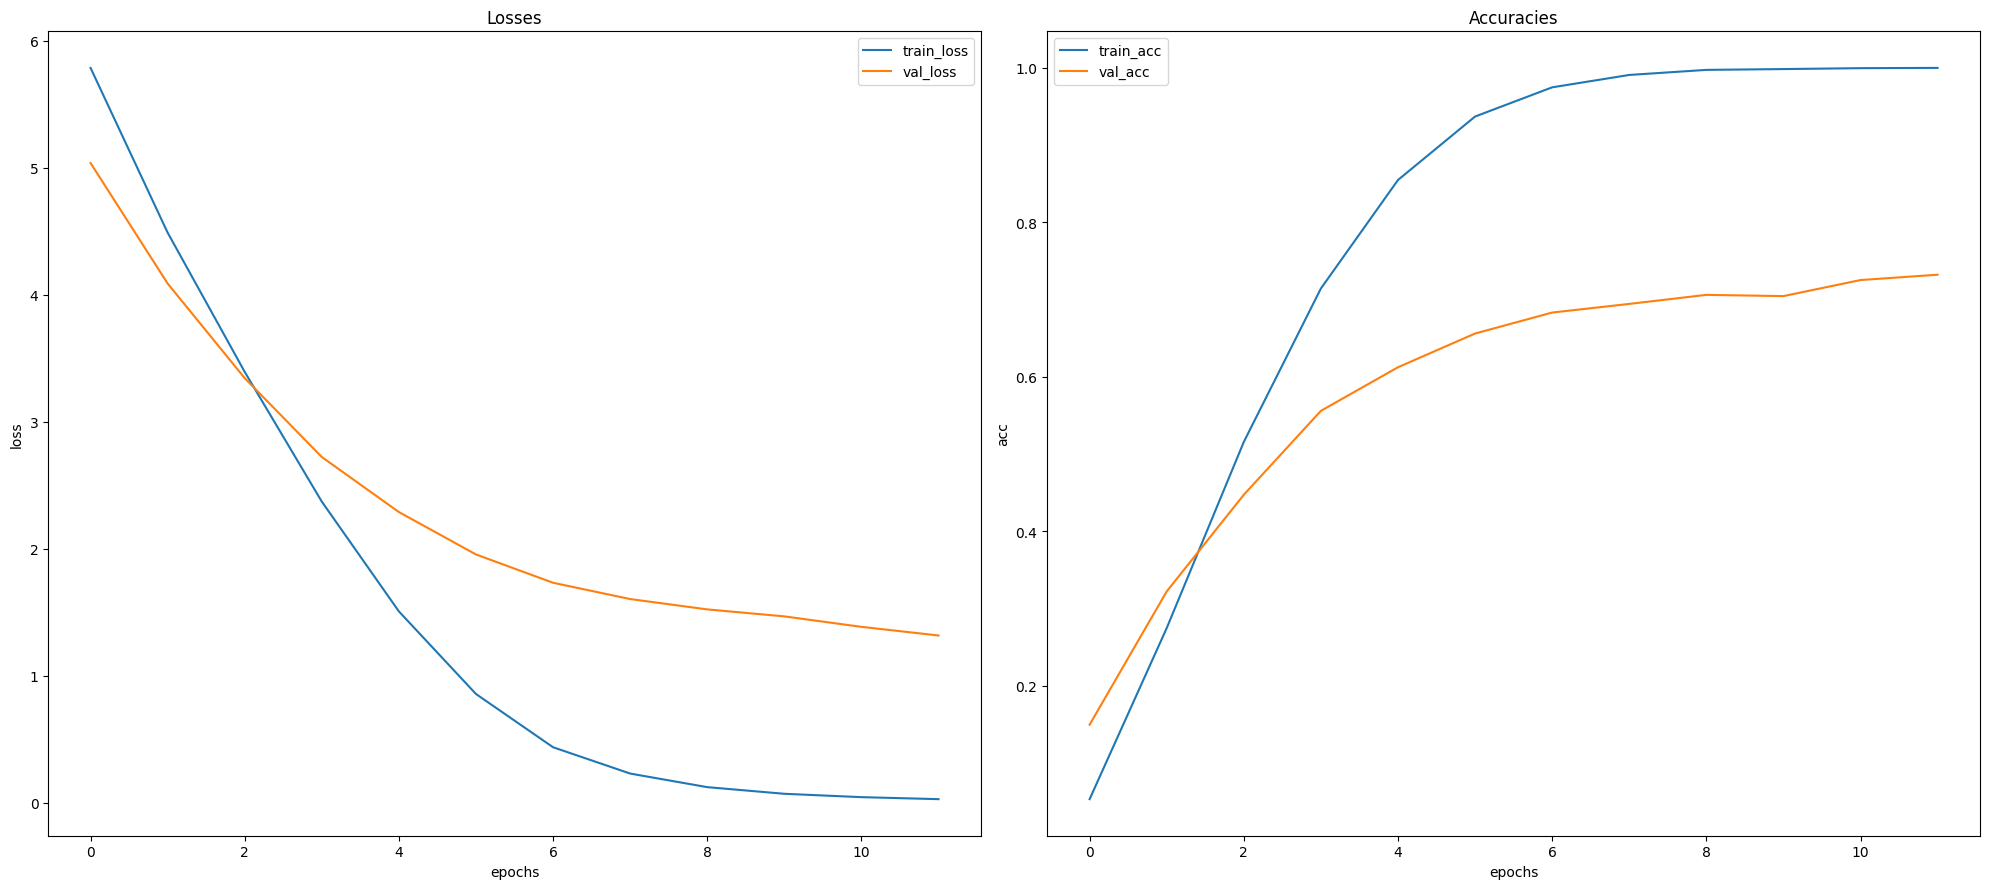

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))

axes[0].plot(train_losses, label="train_loss")
axes[0].plot(val_losses, label="val_loss")
axes[0].legend(loc='best')
axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[0].set_title("Losses")

axes[1].plot(train_acc, label="train_acc")
axes[1].plot(val_acc, label="val_acc")
axes[1].legend(loc='best')
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("acc")
axes[1].set_title("Accuracies")

plt.tight_layout()
plt.show()

In [26]:
torch.save(model, './model.bin')
torch.save(model.state_dict(), './model_weights.bin')

In [17]:
model.eval()
test_correct = 0
test_total_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == test_labels).sum().item()
        test_total_samples += test_labels.size(0)

test_accuracy = test_correct / test_total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7369


Получаем качество классификации 0.73 на тестовой выборке с обучением на кросс энтропии в качестве лосс функции  
Достичь достаточного качества классификации (0.7 accuracy) получилось только на более тяжелой модели resnet50 за 10-12 эпох